### CMB Assigment 2 Program ###

In [1]:
# Program, run imports
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import numpy as np
import seaborn as sns
import requests
sns.set(style="darkgrid")

Create Pandas Dataframe

In [2]:
#df = pd.read_csv("data/21-12-23_complete.csv")
# data_folder = "/Users/Fabian/Desktop/"
data_folder = "/Users/Fabian/Desktop/"
df = pd.read_csv(data_folder + "1dayAll.csv", encoding = "latin")
print(df)
# ['No.', 'Time', 'Source', 'Destination', 'Protocol', 'Length', 'Info', 'dst port']


             No.                        Time           Source  \
0              1  2022-01-16 22:04:03.993585     192.168.0.88   
1              2  2022-01-16 22:04:03.997303      192.168.0.5   
2              3  2022-01-16 22:04:04.055476  199.232.138.248   
3              4  2022-01-16 22:04:04.057104      192.168.0.9   
4              5  2022-01-16 22:04:04.070783  199.232.138.248   
...          ...                         ...              ...   
1117455  1117456  2022-01-17 17:05:50.550259   188.164.238.26   
1117456  1117457  2022-01-17 17:05:50.550547   188.164.238.26   
1117457  1117458  2022-01-17 17:05:50.595386     192.168.0.22   
1117458  1117459  2022-01-17 17:05:50.605007     192.168.0.22   
1117459  1117460  2022-01-17 17:05:50.607387   188.164.238.26   

             Destination Protocol  Length  \
0            192.168.0.5      SSH     190   
1           192.168.0.88      TCP      66   
2            192.168.0.9      TCP     730   
3        199.232.138.248      TCP      

Filter local traffic

In [3]:
# source and destination should not start with 192.168 to filter local network
filtered = df.loc[~df['Source'].str.startswith("192.168", na=False) & df['Destination'].str.startswith("192.168", na=False) |
                 df['Source'].str.startswith("192.168", na=False) & ~df['Destination'].str.startswith("192.168", na=False)]
# filter multicast, broadcast
filtered = filtered.loc[~filtered['Protocol'].str.contains("MDNS")]
filtered = filtered.loc[filtered['Destination'].str.split('.').str[0].astype(int) < 224]

df = filtered.copy()


In [4]:
# helper functions
def utcEntryToTimestamp(entry):
    if '.' in entry:
        row_entry = entry.split(".")[0]
    else:
        row_entry = entry.split(",")[0]
    TIME_FORMAT='%Y-%m-%d %H:%M:%S'
    ts = int(datetime.strptime(row_entry, TIME_FORMAT).timestamp())
    return ts

def utcRowToTimestamp(row):
    return utcEntryToTimestamp(row.at['Time'])
utcRowToTimestamp(df.iloc[0])
# print(df.loc[0].at['Time'])

1642367044

### Protocol packet distribution ###

Protocol
DHCP             38
DNS             698
H1                1
HTTP            554
HTTP/JSON       457
HTTP/XML          2
ICMP             41
NTP             556
QUIC           1827
SSLv2          7018
TCP          548631
TLSv1           200
TLSv1.2      112483
TLSv1.3         851
Name: Source, dtype: int64


/var/folders/px/zjht8g6j4bvglsnf70rp41d80000gn/T/ipykernel_18784/1857181538.py:8: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


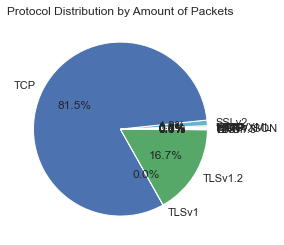

In [5]:
print(df.groupby('Protocol').Source.count())

count_protocol_packets = df.groupby('Protocol').Source.count()

fig, ax = plt.subplots()
plt.title('Protocol Distribution by Amount of Packets')
ax.pie(count_protocol_packets, labels=count_protocol_packets.keys(), autopct='%1.1f%%',)
fig.show()

### Amount of data traffic per protocol ###

/var/folders/px/zjht8g6j4bvglsnf70rp41d80000gn/T/ipykernel_18784/3895533642.py:6: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


Protocol
DHCP             13300
DNS              96797
H1                  77
HTTP            125474
HTTP/JSON       220673
HTTP/XML          2538
ICMP              5121
NTP              50040
QUIC            967873
SSLv2         12790803
TCP          410369042
TLSv1           148764
TLSv1.2       79278291
TLSv1.3         588664
Name: Length, dtype: int64


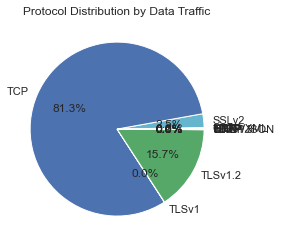

In [6]:
count_protocol_traffic = df.groupby('Protocol').Length.sum()
print(count_protocol_traffic)
fig, ax = plt.subplots()
plt.title('Protocol Distribution by Data Traffic')
ax.pie(count_protocol_traffic, labels=count_protocol_traffic.keys(), autopct='%1.1f%%',)
fig.show()

### Average Data length per Protocol Type ###

Protocol
DHCP          350.000000
DNS           138.677650
H1             77.000000
HTTP          226.487365
HTTP/JSON     482.873085
HTTP/XML     1269.000000
ICMP          124.902439
NTP            90.000000
QUIC          529.760810
SSLv2        1822.570960
TCP           747.987339
TLSv1         743.820000
TLSv1.2       704.802423
TLSv1.3       691.732080
Name: Length, dtype: float64


/var/folders/px/zjht8g6j4bvglsnf70rp41d80000gn/T/ipykernel_18784/212732153.py:11: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


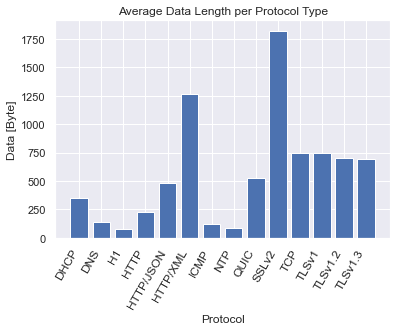

In [7]:
average_protocol_packet_length = df.groupby('Protocol').Length.sum() / df.groupby('Protocol').Length.count()
print(average_protocol_packet_length)
fig, ax = plt.subplots()
ax.tick_params(axis='x', which='major', labelsize=12)
ax.tick_params(axis='x', which='minor', labelsize=12)
plt.xlabel('Protocol')
plt.ylabel('Data [Byte]')
plt.title('Average Data Length per Protocol Type')
ax.bar(average_protocol_packet_length.keys(), average_protocol_packet_length, align='center',)
plt.xticks(rotation=60, ha="right")
fig.show()

### Source addresses ###

In [8]:
print(df.groupby('Source').Time.count())
print(df.groupby('Destination').Time.count().sort_values())

unique_dests = df['Destination'].unique()

# write ip address destinations to file
file1 = open("Testfile.txt","w")
for row in unique_dests:
    file1.write(row + "\n")
file1.close()

Source
104.121.176.87      25
104.122.85.142      18
104.18.30.112        8
104.18.30.82       101
104.199.65.124    3814
                  ... 
92.123.229.80        7
94.130.184.193       1
94.16.116.137        1
99.84.82.10         15
99.84.82.74         31
Name: Time, Length: 300, dtype: int64
Destination
35.175.22.69            1
78.31.67.99             1
85.215.93.134           1
5.1.73.2                1
51.75.67.47             1
                    ...  
192.168.0.121       19319
199.232.138.248     88263
192.168.0.22       149684
188.164.238.26     154839
192.168.0.9        205301
Name: Time, Length: 302, dtype: int64


In [9]:
print(df.groupby('Source').Time.count())
print(df.groupby('Destination').Time.count().sort_values())

Source
104.121.176.87      25
104.122.85.142      18
104.18.30.112        8
104.18.30.82       101
104.199.65.124    3814
                  ... 
92.123.229.80        7
94.130.184.193       1
94.16.116.137        1
99.84.82.10         15
99.84.82.74         31
Name: Time, Length: 300, dtype: int64
Destination
35.175.22.69            1
78.31.67.99             1
85.215.93.134           1
5.1.73.2                1
51.75.67.47             1
                    ...  
192.168.0.121       19319
199.232.138.248     88263
192.168.0.22       149684
188.164.238.26     154839
192.168.0.9        205301
Name: Time, Length: 302, dtype: int64


### DNS requests ###

In [10]:
df_dns = df[df['Protocol'].isin(['DNS'])]
df_dns.head()
df_dns_requests_1 = df_dns[df_dns['Info'].str.contains('Standard query')]
# does not contain response
df_dns_requests_2 = df_dns_requests_1[~df_dns_requests_1['Info'].str.contains('response')]
df_dns_resources = df_dns_requests_2['Info'].apply(lambda x: x.split(' ')[-1]).value_counts()
print(df_dns_resources)
# print(df_dns_requests)
# print(df_dns['Info'])


firetvcaptiveportal.com         79
device-metrics-us.amazon.com    16
msh.amazon.co.uk                16
arcus-uswest.amazon.com         14
api.amazon.com                  14
                                ..
2.android.pool.ntp.org           2
238.36.251.142.in-addr.arpa      1
174.36.251.142.in-addr.arpa      1
19.30.232.85.in-addr.arpa        1
8.0.168.192.in-addr.arpa         1
Name: Info, Length: 63, dtype: int64


### IP Wordlwide location

In [11]:
df_destinations =  df['Destination'].unique()

for dest in df_destinations[:10]: # 10 entries limit for now
    if dest.startswith("192.168"):
            continue
    headers = { 'User-Agent': "keycdn-tools:https://www.example.com" }
    url = "https://tools.keycdn.com/geo.json?host={}".format(dest)
    r = requests.get(url, headers=headers)
    print(r.json() )  


{'status': 'success', 'description': 'Data successfully received.', 'data': {'geo': {'host': '199.232.138.248', 'ip': '199.232.138.248', 'rdns': '199.232.138.248', 'asn': 54113, 'isp': 'FASTLY', 'country_name': 'Germany', 'country_code': 'DE', 'region_name': 'Hesse', 'region_code': 'HE', 'city': 'Frankfurt am Main', 'postal_code': '60313', 'continent_name': 'Europe', 'continent_code': 'EU', 'latitude': 50.1188, 'longitude': 8.6843, 'metro_code': None, 'timezone': 'Europe/Berlin', 'datetime': '2022-01-17 18:16:22'}}}
{'status': 'success', 'description': 'Data successfully received.', 'data': {'geo': {'host': '188.164.238.26', 'ip': '188.164.238.26', 'rdns': '188.164.238.26', 'asn': 198145, 'isp': 'SWM Services GmbH', 'country_name': 'Germany', 'country_code': 'DE', 'region_name': 'Bavaria', 'region_code': 'BY', 'city': 'Munich', 'postal_code': '80331', 'continent_name': 'Europe', 'continent_code': 'EU', 'latitude': 48.1336, 'longitude': 11.5658, 'metro_code': None, 'timezone': 'Europe/B

### Data traffic over time ###

from  1642367044  to  1642435550
77
[26831. 35288. 37334.  4807.  4683.  4636.  4659.  4572.  4542.  4612.
  4622.  4602.  4663.  4588.  4635.  4658.  4664.  7484.  4668.  4580.
  4641.  4642.  4662.  4632.  4647.  4681.  4676.  4687.  4651.  4682.
  4667.  4848.  4784.  4805.  4649.  4651.  4678.  4662.  4690.  4715.
  4658.  6593.  4663.  4635.  4710.  5025.  4728.  4919.  5320.  4697.
  4678.  4687.  4813.  4862.  4676.  4653.  4537.  5238.  4608.  4787.
  4706.  4689.  4674.  5013. 40214. 42578. 42026. 41794. 41614. 40321.
  6205.  4869.  5308.  5137.  5041.  4836.  1967.]
[27749. 36152. 38844.  2120.  2103.  2082.  2096.  2054.  2046.  2090.
  2081.  2075.  2080.  2067.  2081.  2081.  2087.  4700.  2094.  2075.
  2100.  2100.  2104.  2107.  2118.  2129.  2129.  2138.  2127.  2135.
  2134.  2196.  2183.  2175.  2121.  2127.  2130.  2124.  2136.  2133.
  2120.  3363.  2117.  2123.  2131.  2283.  2128.  2222.  2548.  2121.
  2130.  2131.  2184.  2244.  2126.  2115.  2102.  2577.  211

/var/folders/px/zjht8g6j4bvglsnf70rp41d80000gn/T/ipykernel_18784/2888101978.py:44: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/var/folders/px/zjht8g6j4bvglsnf70rp41d80000gn/T/ipykernel_18784/2888101978.py:52: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


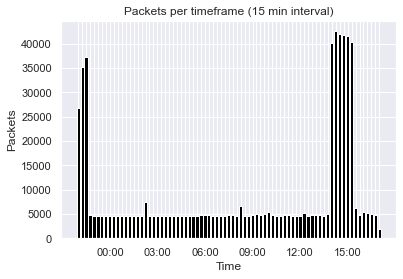

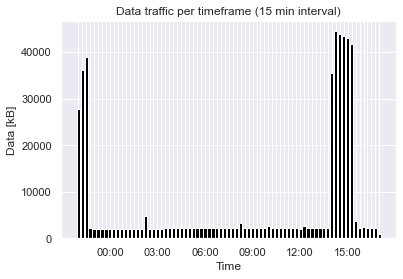

In [12]:
def timeMapping(x):
    # include time difference UTC+1
    time = datetime.utcfromtimestamp(x*min_15_duration + 3600)
    if time.minute == 0 and time.hour % 3 == 0:
        return time.strftime("%H:%M")
    else:
        return ""

# find first and last timestamp, then create data structure
min_15_duration = 60 * 15
df_time_mod = df.copy()
df_time_mod['Time'] = df_time_mod['Time'].apply(lambda x: utcEntryToTimestamp(x)) # map to 15 min window
df_time_mod.head()
first_entry = df_time_mod.iloc[0].at['Time'] // min_15_duration
last_entry = df_time_mod.iloc[-1].at['Time'] // min_15_duration

print('from ', df_time_mod.iloc[0].at['Time'], " to ", df_time_mod.iloc[-1].at['Time'])

count_packets = np.zeros(last_entry - first_entry + 1)
length_packets = np.zeros(last_entry - first_entry + 1)

x_values_packets = list(range(first_entry, last_entry + 1))
print(len(x_values_packets))

mapping_res = list(map(timeMapping, x_values_packets))

# print(mapping_res)

for index, row in df_time_mod.iterrows():
    ts = row.at['Time'] // min_15_duration
    count_packets[ts - first_entry] += 1
    length_packets[ts - first_entry] += row.at['Length']

length_packets = length_packets // 1000
print(count_packets)
print(length_packets)

fig, ax = plt.subplots()
plt.xlabel('Time')
plt.ylabel('Packets')
plt.title('Packets per timeframe (15 min interval)')
plt.xticks(x_values_packets, mapping_res)
ax.bar(x_values_packets, count_packets, color='black')
fig.show()

fig, ax = plt.subplots()
plt.xlabel('Time')
plt.ylabel('Data [kB]')
plt.title('Data traffic per timeframe (15 min interval)')
plt.xticks(x_values_packets, mapping_res)
ax.bar(x_values_packets, length_packets, color='black')
fig.show()